In [38]:
import tensorflow as tf
import numpy as np
import matplotlib
import os

from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import layers, models



# Loading Datasets
data_dir = "./data/train"

# Load the training dataset
train_dataset = image_dataset_from_directory(
    data_dir,
    image_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    label_mode="binary",    # Labels are binary (cats vs. dogs)
    validation_split=0.2,   # Reserve 20% for validation
    subset="training",      # Load training subset
    seed=123                # Fix seed for reproducibility
)

# Load the validation dataset
validation_dataset = image_dataset_from_directory(
    data_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode="binary",
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Data Pipeline Optimization for reducing training latency
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Preprocessing with Layers
normalization_layer = Rescaling(1.0 / 255)

# Apply normalization to the dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optional: Get the class names from the directory structure
class_names = sorted(os.listdir(data_dir))

print("Class names:", class_names)

# Inspect the shape of the first batch (to verify everything is working)
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)

### Build the CNN

model = models.Sequential([
    # Input layer: specify the input shape here
    layers.Input(shape=(150, 150, 3)),  # Input layer specifying the shape of the images

    # First Conv Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second Conv Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Conv Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting

    # Output Layer (Binary Classification)
    layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

model.summary()  # Show model architecture



model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10  
)


val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


model.save('my_model.keras')


Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.
Class names: ['cats', 'dogs']
(32, 150, 150, 3) (32, 1)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 47s 227ms/step - accuracy: 0.5217 - loss: 0.7064 - val_accuracy: 0.5784 - val_loss: 0.6825
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - accuracy: 0.6096 - loss: 0.6619 - val_accuracy: 0.6740 - val_loss: 0.6174
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - accuracy: 0.6737 - loss: 0.6101 - val_accuracy: 0.7108 - val_loss: 0.5841
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 45s 221ms/step - accuracy: 0.7290 - loss: 0.5398 - val_accuracy: 0.7233 - val_loss: 0.5493
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.7708 - loss: 0.4759 - val_accuracy: 0.7495 - val_loss: 0.5321
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - accuracy: 0.8037 - loss: 0.4192 - val_accuracy: 0.7539 - val_loss: 0.5075
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.8438 - loss: 0.3587 - val_accuracy: 0.7514 - val_loss: 0.5451
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 46s 227ms/step - accuracy: 0.8669 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


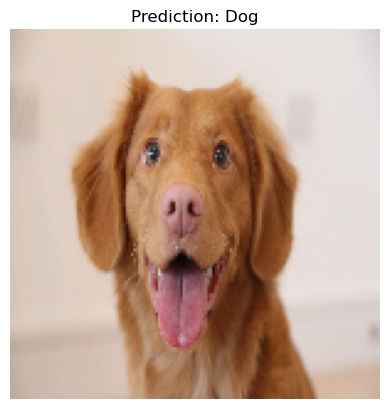

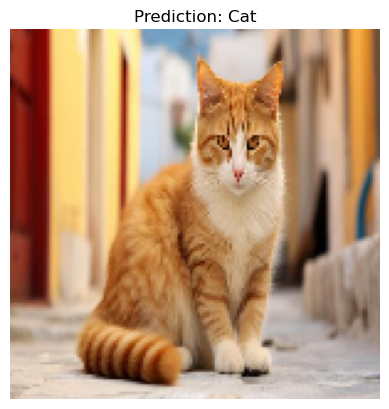

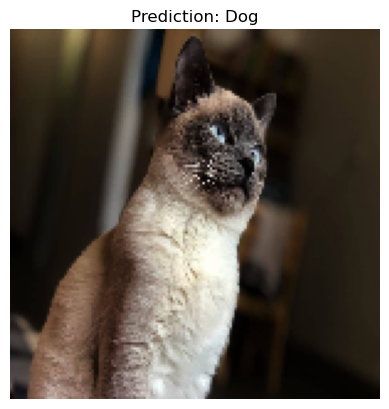

In [44]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model_loaded = load_model('my_model.keras')

# List of image paths to test
img_paths = ['sample_dog.jpg', 'sample.jpg', 'sample3.jpg']

img_array_batch = []

# Prepare the images
for img_path in img_paths:
    img = image.load_img(img_path, target_size=(150, 150))  # Load and resize
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    img_array_batch.append(img_array)

img_array_batch = np.vstack(img_array_batch)

# Predict the class (output: probabilities)
predictions = model_loaded.predict(img_array_batch)

# Output the prediction (1 is for dog, 0 is for cat)
for i, pred in enumerate(predictions):
    pred_label = 'Dog' if pred > 0.5 else 'Cat'
    
    # Display the image along with its prediction
    img = image.load_img(img_paths[i], target_size=(150, 150))
    plt.imshow(img)
    plt.title(f"Prediction: {pred_label}")
    plt.axis('off')  # Turn off axes
    plt.show()
